# Lecture 16

## Datastructures II

### Thursday, October 29th 2020

## Last time:
* Data structures motivation
* Abstract data types
* Sequences
* Linked lists

## This time:
* [Iterators and Iterables](https://docs.python.org/3/glossary.html#term-iterable)
* Trees, B-trees, and BSTs

# From pointers to iterators

One can simply follow the `next` pointers to the next **position** in a linked list. 

In [2]:
import IPython
IPython.display.IFrame('http://pythontutor.com/iframe-embed.html#code=ll%20%3D%20%281,%20%282,%20%283,%20%284,%20None%29%29%29%29&codeDivHeight=400&codeDivWidth=350&cumulative=false&curInstr=0&heapPrimitives=nevernest&origin=opt-frontend.js&py=3&rawInputLstJSON=%5B%5D&textReferences=false">', 
                      width=900, height=250)

This suggests an abstraction of the **position** to an **iterator**.

Such an abstraction allows us to treat arrays and linked lists with an identical interface.

The salient points of this abstraction are:
- The notion of a `next`
- The notion of a `first` to a `last`

We already implemented the sequence protocol.

Now we suggest an additional abstraction that is more fundamental than the notion of a sequence: the **iterable**.

# Iterators and Iterables in `Python`

Similarly to how a sequence is something implementing `__getitem__` and `__len__`, an **iterable** is something implementing `__iter__`. 

`__len__` is not needed and indeed may not make sense.
```python
len(open('fname.txt')) # File iterator has no length
```

Example `14-1` in `Fluent Python`: The `Sentence` sequence and shows how it can be iterated upon.

In [3]:
import reprlib
class Sentence:
    def __init__(self, text): 
        self.text = text
        self.words = text.split()

    def __getitem__(self, index):
        return self.words[index] 

    def __len__(self):
        #completes sequence protocol, but not needed for iterable
        return len(self.words)

    def __repr__(self):
        return 'Sentence(%s)' % reprlib.repr(self.text)

In [4]:
# Sequence'
s = Sentence("the dogs will save the world.")
print(len(s), "   ", s[3], "   ",  s)

6     save     Sentence('the dogs wil...ve the world.')


* [`min()`](https://docs.python.org/3/library/functions.html#min) and [`max()`](https://docs.python.org/3/library/functions.html#max) operate on iterables
* They use [lexicographical ordering](https://en.wikipedia.org/wiki/Lexicographical_order) to do the sort

In [5]:
print(s)
min(s), max(s)

Sentence('the dogs wil...ve the world.')


('dogs', 'world.')

* [`list()`](https://docs.python.org/3/library/functions.html#func-list) also acts on iterables
  - e.g. iterators, sequences, containers supporting iteration

In [6]:
list(s)

['the', 'dogs', 'will', 'save', 'the', 'world.']

To iterate over an object `x`, `Python` automatically calls `iter(x)` (i.e. `x.__iter__`). 

An **iterable** is something that returns an **iterator** when `iter` is called on it.

So how did this work with our sequence? I didn't see `__iter__` there!

1. If `__iter__` is defined, it is called to implement an iterator.
2. If not, `__getitem__` is called starting from index `0`.
3. If no `__iter__` and no `__getitem__`, then raise a `TypeError`.

Any `Python` sequence is iterable because sequences implement `__getitem__`. The standard sequences also implement `__iter__`; for future proofing you should too because  (2) might be deprecated in a future version of `Python`.

We know that `for` operates on iterables:

In [7]:
for i in s:
    print(i)

the
dogs
will
save
the
world.


What's actually going on here?

In [8]:
dir(s)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'text',
 'words']

In [9]:
dir(iter(s))

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__length_hint__',
 '__lt__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

So, we agree that the sentence object `s` is an iterable. (Why?)

[`iter()`](https://docs.python.org/3/library/functions.html#iter) takes an object and returns and iterator object.

Notice that the iterator now has a `__next__` and a `__iter__` but no `__len__` or `__getitem__`!

In [10]:
# A custom for loop
it = iter(s) # Build an iterator from an iterable
while True:
    try:
        nextval = next(it) # Get the next item in the iterator
        print(nextval)
    except StopIteration:
        del it # Iterator is exhausted.  Release reference and discard.
        break

the
dogs
will
save
the
world.


In [11]:
it = iter(s)
print(next(it)) # the
print(next(it)) # dogs
print(next(it)) # will
print(next(it)) # save
print(next(it)) # the
print(next(it)) # world.
print(next(it)) # Exhaust iterator!

the
dogs
will
save
the
world.


StopIteration: 

Once an iterator is exhausted, a new iterator must be built from the iterable if we want to go through it again.

We can completely abstract away a sequence in favor of an iterable (i.e. we don't need to support indexing anymore).

Example `14-4` in `Fluent Python`: The "Iterator Pattern"

In [12]:
class Sentence: # An iterable b/c it has __iter__
    def __init__(self, text): 
        self.text = text
        self.words = text.split()

    def __iter__(self):
        return SentenceIterator(self.words) # Returns an instance of the iterator

    def __repr__(self):
        return 'Sentence(%s)' % reprlib.repr(self.text)

In [13]:
class SentenceIterator: # has __next__ and __iter__
    def __init__(self, words): 
        self.words = words 
        self.index = 0 # Determines the next word to fetch

    def __next__(self): 
        try:
            word = self.words[self.index]
        except IndexError:
            raise StopIteration()
        self.index += 1
        return word

    def __iter__(self):
        return self # Allows iterators to be used where an iterable is expected

In [14]:
s2 = Sentence("What is data science?")

In [15]:
for i in s2:
    print(i)

What
is
data
science?


In [16]:
s2it = iter(s2) # Make the iterable an iterator
print(next(s2it), "\n") # Get the next entry

s2it2 = iter(s2) # Reset the iterator

print(next(s2it), "   ", next(s2it2)) # Get the next entry of s2it and s2it2

What 

is     What


Conveniently re-use the iterable to generate an iterator again.

### Unpacking things a bit more
The [Gang of Four (GoF)](https://en.wikipedia.org/wiki/Design_Patterns) design patterns book says that iterators must also be iterable.

> Use the Iterator pattern
* to access an aggregate object’s contents without exposing its internal representation.
* to support multiple traversals of aggregate objects.
* to provide a uniform interface for traversing different aggregate structures (that is, to support polymorphic iteration).

In [17]:
class BadSentenceIterator: # has __next__
    def __init__(self, words): 
        self.words = words 
        self.index = 0 # Determines the next word to fetch

    def __next__(self): 
        try:
            word = self.words[self.index] 
        except IndexError:
            raise StopIteration() 
        self.index += 1
        return word

#     def __iter__(self):
#         return self

In [18]:
si = BadSentenceIterator(list('Dogs will save the world.'.split()))
for s in si:
    print(s)

TypeError: 'BadSentenceIterator' object is not iterable

In [19]:
class GoodSentenceIterator: # has __next__ and __iter__
    def __init__(self, words): 
        self.words = words 
        self.index = 0 # Determines the next word to fetch

    def __next__(self): 
        try:
            word = self.words[self.index] 
        except IndexError:
            raise StopIteration() 
        self.index += 1
        return word

    def __iter__(self):
        return self

In [20]:
si = GoodSentenceIterator(list('Dogs will save the world.'.split()))
for s in si:
    print(s)

Dogs
will
save
the
world.


### A Warning

While we could have implemented `__next__` in `Sentence` itself, making it an iterator, we will run into the problem of "exhausting an iterator".

```python
class Sentence: # An iterable b/c it has __iter__
    def __init__(self, text): 
        self.text = text
        self.words = text.split()

    def __iter__(self):
        return SentenceIterator(self.words) # Returns an instance of the iterator

    def __repr__(self):
        return 'Sentence(%s)' % reprlib.repr(self.text)
```

The `SentenceIterator` iterator keeps state in `self.index`. We must be able to start over by creating a new instance if we want to re-iterate. `__iter__` in the iterable simply returns the `SentenceIterator`.

"Relationship between iterables and iterators: Python obtains iterators from iterables."

From `Fluent Python` ("Sentence Take #2:  A Classic Iterator"):
> A common cause of errors in building iterables and iterators is to confuse the two. To be clear: iterables have an `__iter__` method that instantiates a new iterator every time. Iterators implement a `__next__` method that returns individual items, and an `__iter__` method that returns self.

`min()` and `max()` also work even though we no longer satisfy the sequence protocol.

`min` and `max` are pairwise comparisons and can be handled via iteration.

The take home message is that in programming with these iterators we don't need either the length or indexing to work to implement many algorithms: we have abstracted these away.

In [21]:
min(s2), max(s2)

('What', 'science?')

## Breakout Room (10 mins)

* Spokesperson: Who will start trick-or-treating earliest on Saturday?
* The Iterator Pattern was a lot of coding --- we had to write two classes to do things properly.
* It's also an example of "eager" programming as opposed to "lazy" programming. Lazy programming allows us to possibly write less code, but mainly to reduce the memory footprint and processing requirements.
* Discuss the iterator pattern applied to sentence objects above.
    - What did we ultimately accomplish when looping over the iterator?
    - Is anything in our iterator pattern implementation wasteful?

# Trees

- A tree is a hierarchical data structure that has a bunch of items.
- Each item may have a value.
- Items may point to other items or not (leaf nodes).
- Each item is pointed to by exactly one other item with the sole exception of the root item.  Nothing points to the root item.

There are many types of trees used to express data structures.  For example,
* Binary Tree
* B-Tree
* Heap
* Multi-way tree

Each of these has many subtypes.

#### Trees arise everywhere:

- In parsing of code
- Evolutionary trees in biology
- Language origin trees
- Unix file system
- HTML tags

Just like with lists, one can consider looking at a tree in two ways: a collection of nodes or a tree with a root and multiple sub-trees.

Today, and in your homework, the focus is on Binary trees.

![](tree.png)



You could also use a tree in which the nodes themselves have data. This is often used to represent a binary tree.

## Some Terminology (Binary Tree)
* The root node is the only node that has nothing pointing to it.
* A node can point to other nodes called children.  
* The node doing the pointing is called the parent node.
* In a binary tree, a given node only points to two other nodes (maximum of two children).
* If a child node does not contain a value, then it is said to be empty (or null).
* A node with pointers to two empty values is called a leaf.

![](../fig/Binary_Tree_Anatomy.png)

## Binary Search Trees (BSTs)
These are binary trees with the requirement that all children to the left of a particular node have lower values and all children to the right have higher values.

There are ways of dealing with repeated values (e.g. storing a counter), but we will just use BSTs that do not have repeated values.

A major benefit of BSTs:
* Time complexity can be $O(\log_{2}(n))$ for a balanced tree where $n$ is the # of items stored in the tree.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

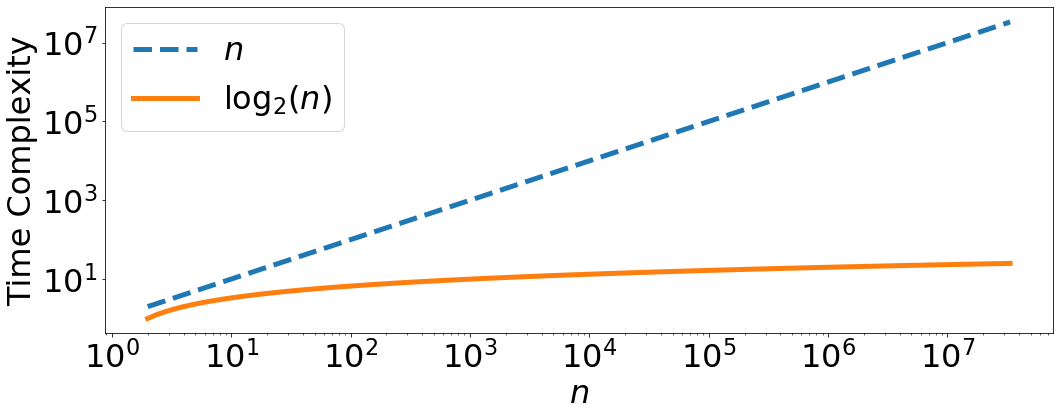

In [22]:
n = np.logspace(1, 25, 100, base=2)
fig, ax = plt.subplots(1,1, figsize=(17,6))
ax.plot(n,n, ls='--', lw=5, label=r'$n$')
ax.plot(n, np.log2(n), lw=5, label=r'$\log_{2}\left(n\right)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$n$', fontsize=32)
ax.set_ylabel(r'Time Complexity', fontsize=32)
ax.tick_params(axis='both', which='major', labelsize=32)
ax.legend(fontsize=32)

An algorithm for the deletion of a node is as follows:
1. If the node to be deleted has no children, then just remove it.
2. If the node to be deleted has only one child, remove the node and replace it with its child.
3. If the node to be deleted has two children, replace the node to be deleted with the maximum value in the left subtree. Finally, delete the node with the maximum value in the left-subtree.

### Case 1

![](del_node_1.png)

### Case 2

![](del_node_2.png)

### Case 3

![](del_node_3.png)